<a href="https://colab.research.google.com/github/HuyenTrang457/MCM/blob/main/Model_1_for_momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install factor_analyzer
!pip install statsmodels
!pip install pingouin
!pip install scipy
!pip install matplotlib
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1
!pip install xgboost pandas matplotlib seaborn scikit-learn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [ ]:
# Load the dataset
data = pd.read_csv("processed_tennis_data.csv")  # Replace with your file path

# Xem trước dữ liệu
print(data.head())


              match_id  Ace  Distance_run  Error_rate_of_serve_no.1  \
0  2023-wimbledon-1301    0     -0.354459                 -0.223061   
1  2023-wimbledon-1301    0     -0.354638                 -0.223061   
2  2023-wimbledon-1301    0     -1.103233                 -0.223061   
3  2023-wimbledon-1301    0     -4.429419                 -0.223061   
4  2023-wimbledon-1301    1     -0.053368                 -0.223061   

   Lead_score  Net_pt_won  Rally_count  Server_pt  Speed_mph  Game_victor  \
0   -0.047000   -0.284381    -0.353674          0  -1.429909            0   
1   -0.931929   -0.284381    -0.666960          0   0.459150            0   
2   -0.047000   -0.284381     0.272900          0   0.623416            0   
3   -0.931929   -0.284381     3.092482          0   1.444746            0   
4   -0.047000   -0.284381    -0.666960          0  -0.033648            0   

   Break_Point  Return_depth_D  Return_depth_ND  Serve_depth_CTL  \
0            0               0            

In [ ]:
data['Log_Speed_mph'] = np.log1p(data['Speed_mph'])
data['Log_Speed_mph'] = data['Log_Speed_mph'].fillna(data['Speed_mph'].mean())
data['Interaction_Rally_Speed'] = data['Rally_count'] * data['Speed_mph']
features = [
    'Ace', 'Distance_run', 'Error_rate_of_serve_no.1', 'Rally_count',
    'Server_pt', 'Game_victor', 'Log_Speed_mph', 'Interaction_Rally_Speed'
]
print(data['Log_Speed_mph'] )

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[features])  # 'features' là danh sách các cột cần chuẩn hóa

# Áp dụng PCA
pca = PCA(n_components=len(features))  # Số thành phần chính = số lượng biến
pca.fit(scaled_data)

# Phương sai giải thích bởi từng thành phần chính
explained_variance_ratio = pca.explained_variance_ratio_

# Phương sai tích lũy
cumulative_variance = explained_variance_ratio.cumsum()

print("Explained Variance Ratio:", explained_variance_ratio)
print("Cumulative Variance:", cumulative_variance)


Explained Variance Ratio: [1.90583285e-01 1.58681635e-01 1.52346248e-01 1.40796878e-01
 1.35576977e-01 1.27417890e-01 9.45970867e-02 2.60925311e-35]
Cumulative Variance: [0.19058328 0.34926492 0.50161117 0.64240805 0.77798502 0.90540291
 1.         1.        ]


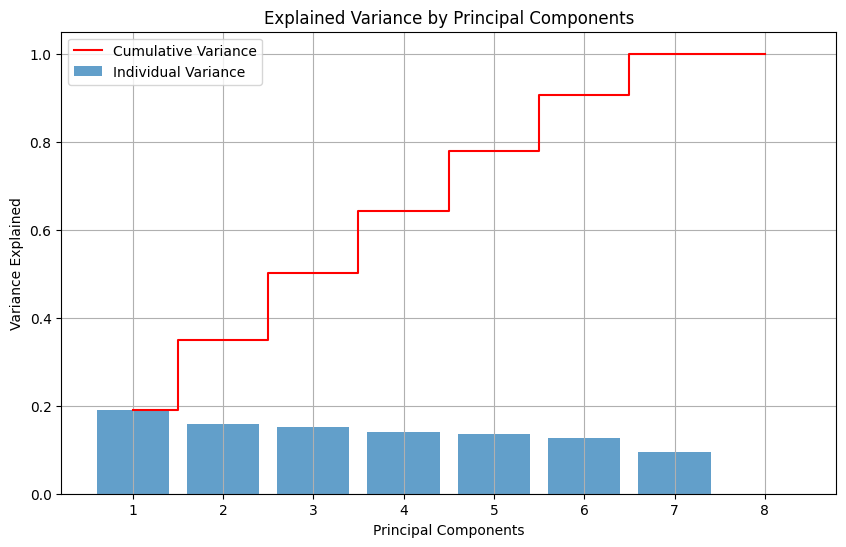

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(features) + 1), explained_variance_ratio, alpha=0.7, label='Individual Variance')
plt.step(range(1, len(features) + 1), cumulative_variance, where='mid', label='Cumulative Variance', color='red')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Hệ số tải (loadings)
loadings = pd.DataFrame(
    pca.components_.T,  # Ma trận hệ số tải từ PCA
    columns=[f'PC{i+1}' for i in range(len(features))],  # Tên các thành phần chính
    index=features  # Tên các biến gốc
)

# Tóm tắt phương sai
variance_summary = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(features))],
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Variance': cumulative_variance
})


In [ ]:
# Hiển thị bảng loadings (PC1-PC3)
print("PCA Loadings (PC1-PC3):")
print(loadings.iloc[:, :3])  # Hiển thị chỉ 3 thành phần chính đầu tiên

# Hiển thị bảng phương sai
print("\nExplained Variance Summary:")
print(variance_summary)


PCA Loadings (PC1-PC3):
                                   PC1           PC2           PC3
Ace                      -3.559011e-01  6.220342e-01 -2.443632e-01
Distance_run             -1.897682e-02  3.598238e-02  6.272342e-01
Error_rate_of_serve_no.1 -1.430958e-01 -2.067963e-01 -5.837080e-01
Rally_count               6.749739e-01  1.465727e-01  1.803335e-02
Server_pt                 3.469447e-18  5.551115e-17  1.110223e-16
Game_victor              -1.272440e-01  2.058073e-01  4.063892e-01
Log_Speed_mph            -3.438508e-01  4.596065e-01  5.880939e-02
Interaction_Rally_Speed  -5.123316e-01 -5.421583e-01  1.929067e-01

Explained Variance Summary:
  Principal Component  Explained Variance Ratio  Cumulative Variance
0                 PC1              1.905833e-01             0.190583
1                 PC2              1.586816e-01             0.349265
2                 PC3              1.523462e-01             0.501611
3                 PC4              1.407969e-01             0.642408

Nhận xét từ biểu đồ và bảng hệ số tải (loadings)
PC1:
Rally_count (0.6749739) có ảnh hưởng mạnh nhất đến PC1 và có hệ số dương lớn nhất → PC1 đại diện cho yếu tố liên quan đến số lượt rally.
Interaction_Rally_Speed (-0.5123316) có hệ số âm lớn, cho thấy tốc độ tương tác rally tác động ngược chiều đến PC1.
PC2:
Ace (0.6220342) có ảnh hưởng mạnh nhất, tiếp theo là Log_Speed_mph (0.4596065) → PC2 có thể đại diện cho kỹ năng giao bóng và tốc độ.
PC3:
Distance_run (0.6272342) và Error_rate_of_serve_no.1 (-0.5837080) chi phối mạnh → PC3 đại diện cho yếu tố khoảng cách di chuyển và tỷ lệ lỗi giao bóng.
Explained Variance Ratio: Cho biết tỷ lệ phương sai được giải thích bởi từng thành phần chính.

PC1 (19.05%), PC2 (15.87%), và PC3 (15.23%) cùng giải thích 50.16% phương sai của dữ liệu → 3 thành phần chính giữ lại một nửa thông tin từ dữ liệu ban đầu.
Với 5 thành phần chính, tỷ lệ phương sai tích lũy đạt 77.80% → đủ để giữ lại phần lớn thông tin.
Cumulative Variance:

Sau PC6, phương sai tích lũy đạt 90.54%. Các thành phần từ PC7 trở đi đóng góp rất ít phương sai, nên có thể loại bỏ.


Tính Momentum_temp bằng cách mỗi thành phần chính được nhân với trọng số dựa trên Explained Variance Ratio.
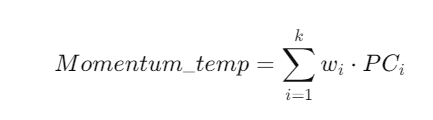

In [ ]:
weights = pca.explained_variance_ratio_[:6]  # Lấy trọng số cho 6 thành phần đầu
data['Momentum_temp'] = (pca.transform(scaled_data)[:, :6] * weights).sum(axis=1)


In [ ]:

X = data[features]
y = data['Momentum_temp']

#chia tập huấn luyện
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Chọn model XGBost để train vì sao?
1. Quan hệ phi tuyến:
XGBoost rất mạnh trong việc phát hiện các mối quan hệ phi tuyến giữa các biến, điều mà các mô hình tuyến tính không làm được.
Hỗ trợ tương tác giữa các đặc trưng (features):
2. Bản chất của XGBoost là xây dựng các cây quyết định, giúp nắm bắt các tương tác giữa các biến mà không cần tính toán thủ công (feature engineering).
3. Rất hiệu quả với tập dữ liệu không quá lớn

In [ ]:

#Dùng model Xgbost để train mô hình
# Dự đoán trên tập kiểm tra
# Initialize XGBoost model
xgb_model = XGBRegressor(random_state=42, n_estimators=200, max_depth=5, learning_rate=0.1)

# Train the model
xgb_model.fit(X_train, y_train)
y_pred_test = xgb_model.predict(X_test)

# Tính các chỉ số trên tập kiểm tra
r2_test = r2_score(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

# So sánh với tập huấn luyện
y_pred_train = xgb_model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print(f"Train R²: {r2_train:.4f}, Train RMSE: {rmse_train:.4f}")
print(f"Test R²: {r2_test:.4f}, Test RMSE: {rmse_test:.4f}")


Train R²: 0.9976, Train RMSE: 0.0190
Test R²: 0.9509, Test RMSE: 0.0894


In [ ]:
from sklearn.model_selection import cross_val_score

# Tính R² với Cross-Validation (5 folds)
cv_r2 = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')
cv_rmse = -cross_val_score(xgb_model, X, y, cv=5, scoring='neg_root_mean_squared_error')

print(f"Cross-Validated R²: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
print(f"Cross-Validated RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")


Cross-Validated R²: 0.9642 ± 0.0177
Cross-Validated RMSE: 0.0716 ± 0.0247


1. Hiệu suất trên tập huấn luyện
Train R²: 0.9976

Mô hình đã giải thích được 99.76% phương sai của biến mục tiêu (Momentum_temp) trên tập huấn luyện.
Đây là một giá trị rất cao, cho thấy mô hình đã học tốt trên tập huấn luyện.
Train RMSE: 0.0190

Sai số trung bình trên tập huấn luyện chỉ khoảng 0.019 đơn vị, rất nhỏ so với phạm vi dữ liệu.
Điều này khẳng định mô hình hoạt động cực kỳ chính xác trên tập huấn luyện.
2. Hiệu suất trên tập kiểm tra
Test R²: 0.9509

Mô hình giải thích được 95.09% phương sai trên tập kiểm tra, một kết quả rất cao.
Dù thấp hơn tập huấn luyện, mức độ chênh lệch nhỏ, cho thấy mô hình tổng quát hóa tốt.
Test RMSE: 0.0894

Sai số trung bình trên tập kiểm tra là 0.0894 đơn vị, lớn hơn tập huấn luyện nhưng vẫn đủ nhỏ để khẳng định mô hình dự đoán chính xác.
3. Hiệu suất với kiểm tra chéo (Cross-Validation)
Cross-Validated R²: 0.9642 ± 0.0177

Mô hình giải thích được 96.42% phương sai trung bình trong các lần kiểm tra chéo.
Sai số chuẩn (±0.0177) nhỏ, chứng tỏ mô hình ổn định trên các tập dữ liệu khác nhau.
Cross-Validated RMSE: 0.0716 ± 0.0247

Sai số trung bình trên các tập kiểm tra trong kiểm tra chéo là 0.0716 đơn vị.
Sai số chuẩn (±0.0247) cho thấy sai số không dao động nhiều giữa các lần kiểm tra, khẳng định sự nhất quán của mô hình.
Từ đó cho thấy hoạt động của mô hình thật sự hiệu quả và chúng em đã chứng minh được mô hình không bị overfitting.

In [ ]:
# Create a comparison dataframe
comparison_df = pd.DataFrame({
    "Metric": ["R²", "RMSE", "MAE", "MAPE (%)"],
    "Train": [r2_train, rmse_train, mae_train, mape_train],
    "Test": [r2_test, rmse_test, mae_test, mape_test]
})

# Round the results
comparison_df = comparison_df.round(4)

# Display the dataframe
print(comparison_df)

     Metric    Train     Test
0        R²   0.9976   0.9509
1      RMSE   0.0190   0.0894
2       MAE   0.0106   0.0207
3  MAPE (%)  20.6388  20.1156


Nhận xét:


1. MAE (Train: 0.0106, Test: 0.0207):  Sai số trung bình tuyệt đối trên tập kiểm tra gấp đôi tập huấn luyện nhưng vẫn rất thấp, cho thấy mô hình hoạt động ổn định.
Lý do Sai số trung bình tuyệt đối trên tập kiểm tra gấp đôi tập huấn luyện có thể là do mức độ tổng quát hóa của mô hình hoặc độ chính xác tổng thể cao.
2. MAPE (Train: 20.64%, Test: 20.12%): Sai số tỷ lệ phần trăm trung bình trên cả hai tập gần tương đương, chứng minh sự ổn định của mô hình.
Qua đó, vô hình trung chúng ta có thể mô hình hoạt động rất tốt và ổn định.

In [ ]:
xgb_feature_importance = pd.DataFrame({
    "Feature": features,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Hiển thị tầm quan trọng
print(xgb_feature_importance)


                    Feature  Importance
7   Interaction_Rally_Speed    0.238139
3               Rally_count    0.227929
0                       Ace    0.169071
1              Distance_run    0.167575
6             Log_Speed_mph    0.147514
2  Error_rate_of_serve_no.1    0.030860
5               Game_victor    0.018912
4                 Server_pt    0.000000


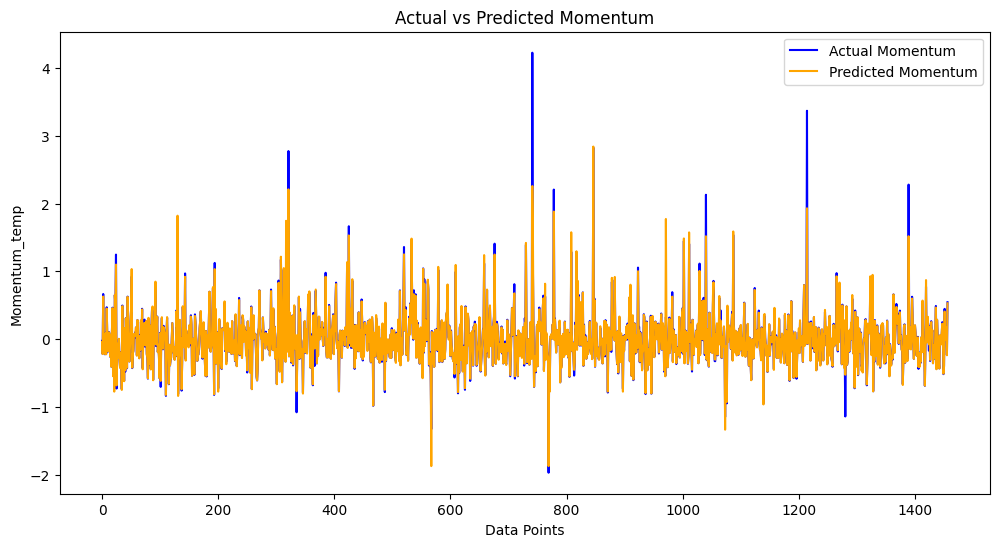

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Momentum', color='blue')
plt.plot(y_pred_xgb, label='Predicted Momentum', color='orange')
plt.title("Actual vs Predicted Momentum")
plt.xlabel("Data Points")
plt.ylabel("Momentum_temp")
plt.legend()
plt.show()


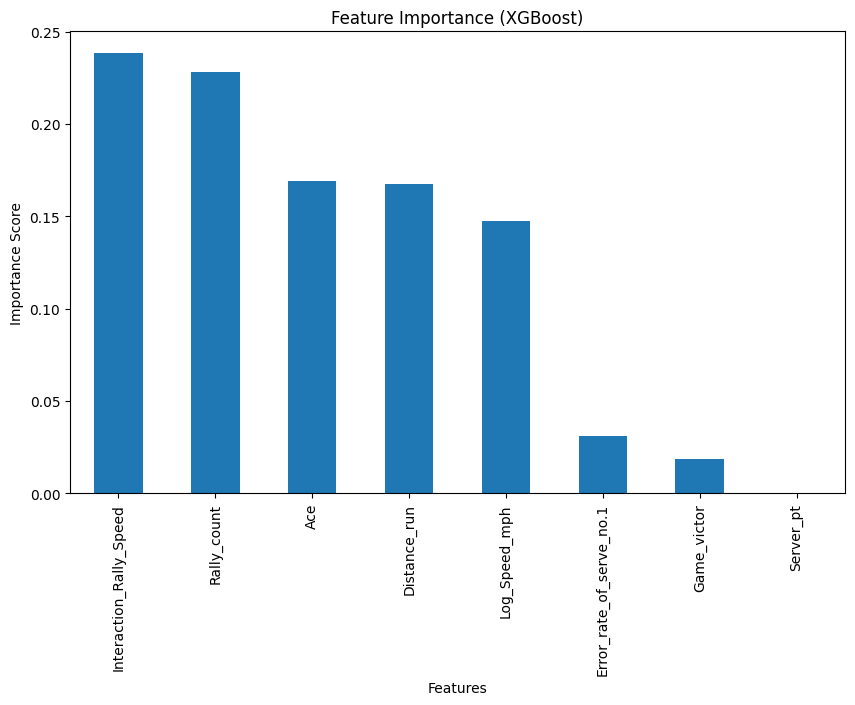

In [ ]:
xgb_feature_importance.plot(kind='bar', x='Feature', y='Importance', legend=False, figsize=(10, 6))
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


Chúng em muốn tối ưu để đạt tỷ lệ cao hơn một chút nữa nên dùng kĩ thuật Grid Search nhắm tối ưu hóa các tham số mô hình và tìm ra mô hình tốt nhất.


In [ ]:
# Định nghĩa lưới tham số
param_grid = {
    'n_estimators': [100, 200, 300],       # Số lượng cây
    'max_depth': [3, 5, 7],               # Độ sâu tối đa
    'learning_rate': [0.01, 0.1, 0.2],    # Tốc độ học
    'subsample': [0.8, 1.0],              # Phần trăm mẫu sử dụng
    'colsample_bytree': [0.8, 1.0],       # Phần trăm đặc trưng sử dụng
}

# Khởi tạo mô hình XGBoost
xgb_model = XGBRegressor(random_state=42)

# Thiết lập GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',         # Tối ưu hóa R²
    cv=3,                 # Sử dụng 3-fold cross-validation
    verbose=1,
    n_jobs=-1             # Sử dụng toàn bộ CPU
)

# Thực hiện Grid Search
grid_search.fit(X_train, y_train)

# Lấy tham số tốt nhất và điểm số tốt nhất
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Huấn luyện mô hình với tham số tốt nhất
best_xgb_model = grid_search.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Đánh giá mô hình tối ưu
optimized_r2 = r2_score(y_test, y_pred_best_xgb)
optimized_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))
mae_test = mean_absolute_error(y_test, y_pred_best_xgb)
mape_test = np.mean(np.abs((y_test - y_pred_best_xgb) / y_test)) * 100
print("Best Parameters:", best_params)
optimized_metrics = {
    "Metric": ["R²", "RMSE", "MAE", "MAPE (%)"],
    "Value": [optimized_r2, optimized_rmse, mae_test, mape_test]
}

# Tạo DataFrame để hiển thị
optimized_metrics_df = pd.DataFrame(optimized_metrics)
optimized_metrics_df = optimized_metrics_df.round(4)  # Làm tròn kết quả để dễ đọc

# Xuất kết quả
print(optimized_metrics_df)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
     Metric    Value
0        R²   0.9606
1      RMSE   0.0801
2       MAE   0.0206
3  MAPE (%)  25.6050


. Kết quả cho thấy
mô hình được tối ưu hóa đạt được 𝑅^2 cải tiến là 0,9606 và RMSE giảm xuống còn 0,0801 trên
bộ thử nghiệm, thể hiện sự cải tiến đáng kể so với phiên bản ban đầu.

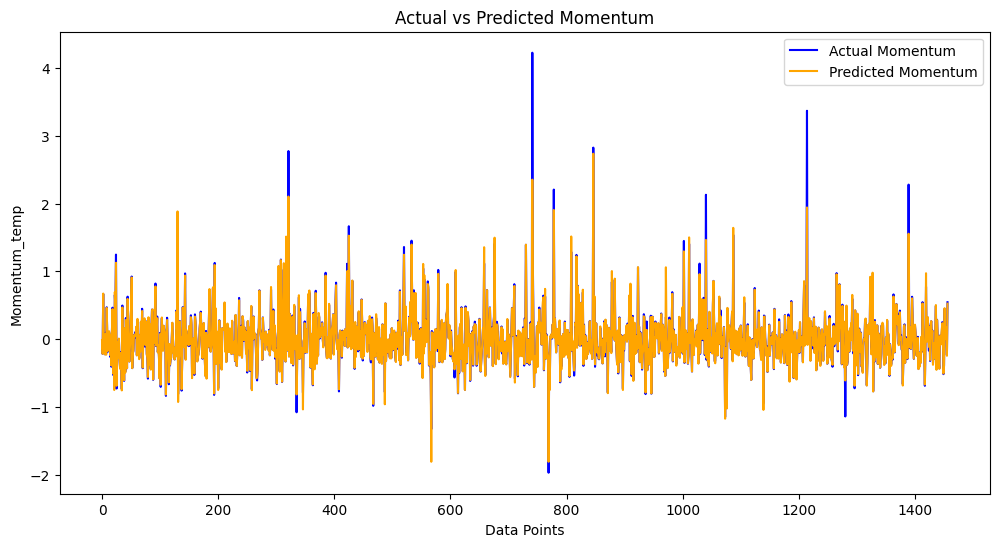

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Momentum', color='blue')
plt.plot(y_pred_best_xgb, label='Predicted Momentum', color='orange')
plt.title("Actual vs Predicted Momentum")
plt.xlabel("Data Points")
plt.ylabel("Momentum_temp")
plt.legend()
plt.show()

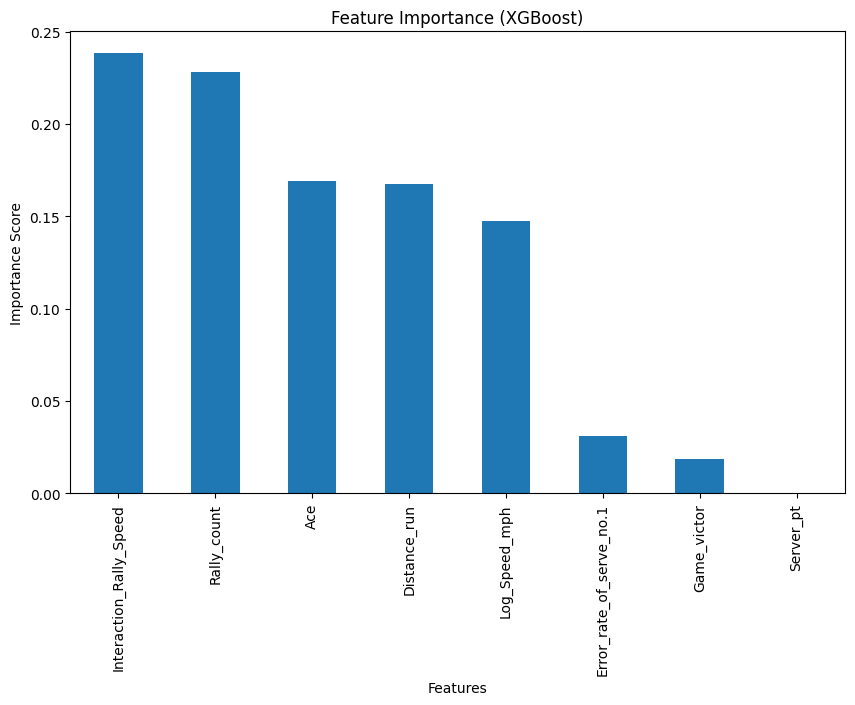

In [ ]:
xgb_feature_importance.plot(kind='bar', x='Feature', y='Importance', legend=False, figsize=(10, 6))
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


In [ ]:
# Initialize a dictionary to store results for each match
match_results = {}

# Iterate over each unique match_id
for match_id in data['match_id'].unique():
    try:
        # Filter data for the current match
        match_data = data[data['match_id'] == match_id]

        # Check if there's enough data for training and testing
        if len(match_data) < 10:  # Arbitrary threshold to ensure enough data points
            print(f"Skipping match {match_id} due to insufficient data points.")
            continue

        # Extract features (X) and target (y)
        X_match = match_data[features] # Features from PCA
        y_match = match_data['Momentum_temp']        # Target variable

        # Split data into train and test sets
        X_train_match, X_test_match, y_train_match, y_test_match = train_test_split(
            X_match, y_match, test_size=0.2, random_state=42
        )

        # Train the model on the current match
        best_xgb_model.fit(X_train_match, y_train_match)

        # Predict on the test set
        y_pred_match = best_xgb_model.predict(X_test_match)

        # Evaluate performance
        r2_match = r2_score(y_test_match, y_pred_match)
        rmse_match = np.sqrt(mean_squared_error(y_test_match, y_pred_match))

        # Store the results
        match_results[match_id] = {
            'R²': r2_match,
            'RMSE': rmse_match
        }
        print(f"Analyzed match: {match_id}, R²: {r2_match:.4f}, RMSE: {rmse_match:.4f}")

    except Exception as e:
        # Handle any unexpected errors for a specific match
        print(f"Error processing match {match_id}: {e}")
        continue

# Convert the results dictionary to a DataFrame for easier analysis
match_results_df = pd.DataFrame.from_dict(match_results, orient='index')
match_results_df.index.name = 'Match_ID'

# Display the results


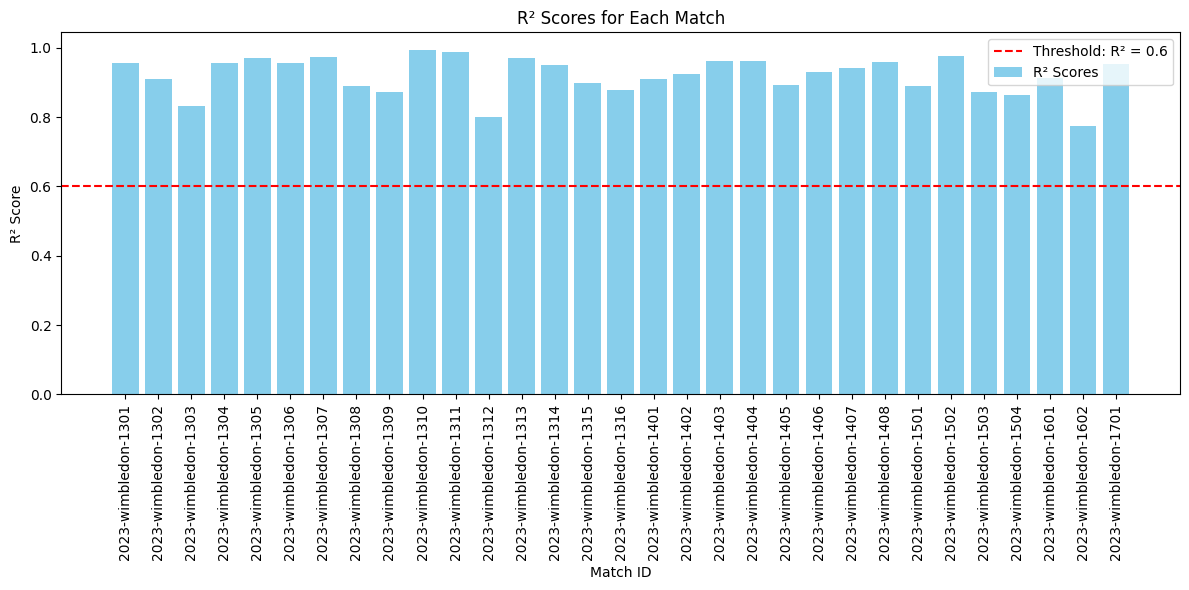

In [ ]:
import matplotlib.pyplot as plt

# Extract data for plotting
match_ids = match_results_df.index  # Match IDs
r2_scores = match_results_df['R²']  # R² values

# Plot R² values
plt.figure(figsize=(12, 6))
plt.bar(match_ids, r2_scores, color='skyblue', label='R² Scores')
plt.axhline(y=0.6, color='red', linestyle='--', label='Threshold: R² = 0.6')
plt.xticks(rotation=90)
plt.xlabel('Match ID')
plt.ylabel('R² Score')
plt.title('R² Scores for Each Match')
plt.legend()
plt.tight_layout()
plt.show()


Hầu hết các trận đấu đều có chỉ số R² trên 0.6, thậm chí rất nhiều trận còn >0.9 chứng tỏ mô hình không chỉ hoạt động tốt trên tổng thể mà còn xuất sắc trên từng trận.
Một số trận vòi do số set trong 1 trận ít hơn dẫn đến data train ít hơn nên chỉ số này thấp hơn nhưng vẫn rất tốt.

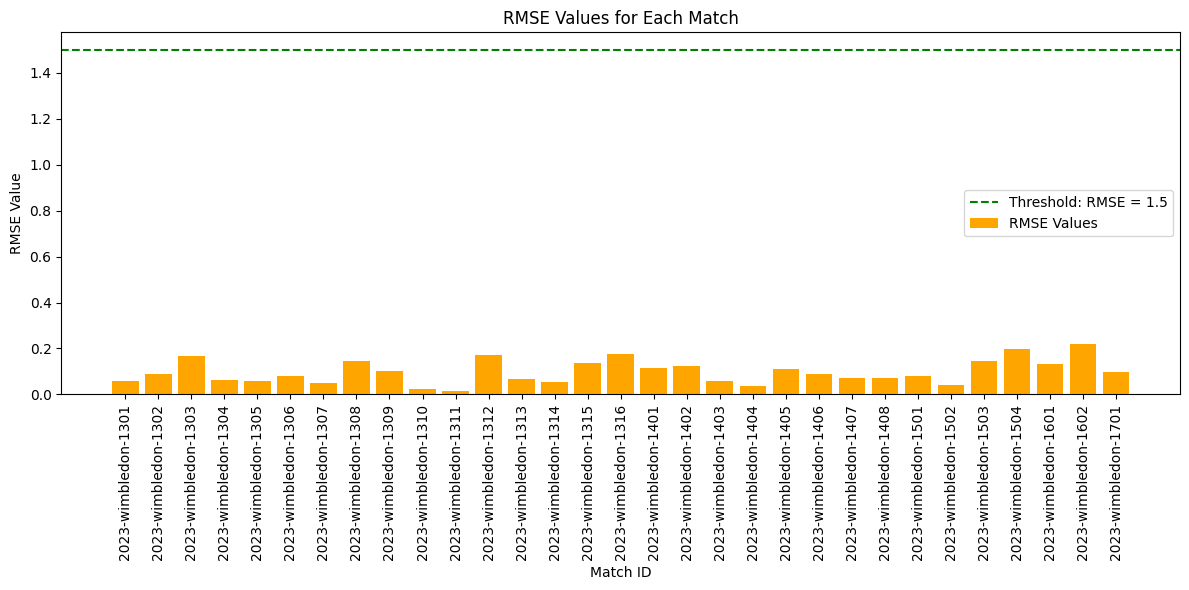

In [ ]:
# Extract RMSE values
rmse_values = match_results_df['RMSE']  # RMSE values

# Plot RMSE values
plt.figure(figsize=(12, 6))
plt.bar(match_ids, rmse_values, color='orange', label='RMSE Values')
plt.axhline(y=1.5, color='green', linestyle='--', label='Threshold: RMSE = 1.5')
plt.xticks(rotation=90)
plt.xlabel('Match ID')
plt.ylabel('RMSE Value')
plt.title('RMSE Values for Each Match')
plt.legend()
plt.tight_layout()
plt.show()


RMSE của hầu hết các trận đấu thấp (dưới 1.5, ngưỡng đánh giá tốt).
Một số trận đấu có RMSE cao hơn, có thể là do lượng data cho từng trận là không đều nên các trận có số data ít hơn sẽ có RMSE cao hơn nhưng không đáng kể. Vô hình trung đây cũng là 1 mô hình tốt.

In [ ]:
data['Predicted_Momentum'] = best_xgb_model.predict(data[features])
data.to_csv("predicted_momentum.csv", index=False)
print("File has been saved as predicted_momentum.csv")


File has been saved as predicted_momentum.csv
